<a href="https://colab.research.google.com/github/ramajoballester/mil_deeplearning/blob/main/4_aplicaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sesión 4. Aplicaciones y casos de uso

# Detección con YOLOv5

In [ ]:
! pip install -q torchmetrics torchsummary

     |████████████████████████████████| 419 kB 18.4 MB/s 


In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision
import torchmetrics
from torch import nn
from torchsummary import summary

[Repositorio YOLOv5](https://github.com/ultralytics/yolov5)

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
# model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)

In [ ]:
! wget -nc -P ./data/ https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
! wget -nc -P ./data/ https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
! unzip -q ./data/Flickr8k_Dataset.zip -d ./data/Flickr8k/
! unzip -q ./data/Flickr8k_text.zip -d ./data/Flickr8k/

In [ ]:
transf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((640, 640))
])
dataset = torchvision.datasets.Flickr30k(root='./data/Flickr8k/Flicker8k_Dataset',
                                        ann_file='./data/Flickr8k/Flickr8k.token.txt',
                                        transform=transf)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, 1, shuffle=True)
data_iter = iter(dataloader)

In [ ]:
x = next(data_iter)

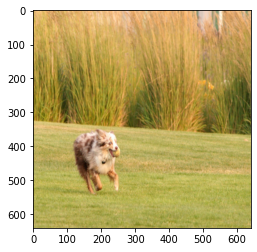

In [ ]:
%matplotlib inline
plt.imshow(x[0][0].permute(1, 2, 0));

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
def get_bboxes_labels(preds: torch.tensor,
                      conf_threshold: int,
                      iou_threshold: int,
                      nms=True) -> (torch.tensor, torch.tensor):

    candidates = preds[..., 4] > conf_threshold
    final_preds = preds[candidates]

    # Bounding boxes
    bboxes = final_preds[:, 0:4]
    conf = final_preds[:, 4]
    w = bboxes[:, 2]
    h = bboxes[:, 3]
    labels = final_preds[:,5:]
    bboxes[:, 0] = bboxes[:, 0] - bboxes[:, 2]/2
    bboxes[:, 1] = bboxes[:, 1] - bboxes[:, 3]/2
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]

    # Non-max suppression
    if nms:
        selected_preds = torchvision.ops.nms(bboxes, conf, iou_threshold)
        bboxes = bboxes[selected_preds]
        conf = conf[selected_preds]
        w = w[selected_preds]
        h = h[selected_preds]
        labels = labels[selected_preds]

    return bboxes, labels

In [ ]:
def draw_bboxes(img, bboxes, labels, classes, color='red', width=5, font_size=50):
    assert len(bboxes) == len(labels)

    for i in range(len(bboxes)):
        img = torchvision.utils.draw_bounding_boxes(img,
                                          torch.unsqueeze(bboxes[i], dim=0),
                                          [classes[labels.argmax(dim=1)[i]]],
                                          colors=color, width=width,
                                          font="/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                                          font_size=font_size)
        
    return img

In [ ]:
preds = model(x[0].to(device))

In [ ]:
preds.shape

torch.Size([1, 25200, 85])

In [ ]:
conf_threshold = 0.5
iou_threshold = 0.7
bboxes, labels = get_bboxes_labels(preds, conf_threshold, iou_threshold, nms=True)

In [ ]:
bboxes.shape

torch.Size([1, 4])

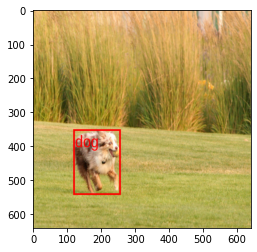

In [ ]:
img = draw_bboxes((x[0][0]*255).to(torch.uint8).cpu(),
                  bboxes, labels, names, width=5)
plt.imshow(img.permute(1, 2, 0))

# Segmentación semántica (UW-Madison)

[UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation)

In [ ]:
! pip install -q segmentation_models_pytorch torchmetrics

     |████████████████████████████████| 88 kB 3.9 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
     |████████████████████████████████| 376 kB 1.1 MB/s 


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c uw-madison-gi-tract-image-segmentation
! mkdir ./data
! mv uw-madison-gi-tract-image-segmentation.zip ./data/
! unzip -q ./data/uw-madison-gi-tract-image-segmentation.zip -d ./data/

100% 2.29G/2.30G [01:26<00:00, 54.5MB/s]
100% 2.30G/2.30G [01:26<00:00, 28.5MB/s]
mkdir: cannot create directory ‘./data’: File exists


In [ ]:
import torch
import torchmetrics
import os
import pandas as pd
import glob
import argparse
import random

import torch.nn.functional as F
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as A
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from scipy.spatial.distance import directed_hausdorff as hausdorff_dist
import cv2

In [ ]:
# CONFIG
DATA_PATH = './data/train'
CSV_PATH = './data/train.csv'

In [ ]:
class Args():
    arch = 'efficientnet-b0'
    batch_size = 1
    epochs = 10
    img_height = 224
    img_width = 224
    log_name = 'prueba'
    lr = 1e-4
    min_lr = 5e-6
    num_workers = 1
    val_split = 0.3

args = Args()

In [ ]:
df = pd.read_csv(CSV_PATH)

In [ ]:
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


## Reproducibilidad

In [ ]:
def seed_all(seed):
    if not seed:
        seed = 10
    print("[Using Seed:",seed,"]")
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split("_")[0]
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    folder = os.path.join(root_dir, case_folder, day_folder, "scans")
    file = glob.glob(f"{folder}/{file_starter}*")
    return file[0]

In [ ]:
df["segmentation"] = df["segmentation"].astype("str")
df["case_id"] = df["id"].apply(lambda x: x.split("_")[0][4:]).astype(int)
df["day_id"] = df["id"].apply(lambda x: x.split("_")[1][3:]).astype(int)
df["slice_id"] = df["id"].apply(lambda x: x.split("_")[-1]).astype(int)
df["path"] = df["id"].apply(lambda x: fetch_file_from_id(DATA_PATH, x))
df["width"] = df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[3]).astype(int)
df["height"] = df["path"].apply(lambda x: os.path.split(x)[-1].split("_")[2]).astype(int)

df_preprocess = pd.DataFrame({'id':df['id'][::3]})
df_preprocess['large_bowel'] = df['segmentation'][::3].values
df_preprocess['small_bowel'] = df['segmentation'][1::3].values
df_preprocess['stomach'] = df['segmentation'][2::3].values
df_preprocess['path'] = df['path'][::3].values
df_preprocess['case_id'] = df['case_id'][::3].values
df_preprocess['day_id'] = df['day_id'][::3].values
df_preprocess['slice_id'] = df['slice_id'][::3].values
df_preprocess['width'] = df['width'][::3].values
df_preprocess['height'] = df['height'][::3].values

df_preprocess.reset_index(inplace=True,drop=True)
df_preprocess.fillna('',inplace=True); 
df_preprocess['count'] = np.sum(df_preprocess.iloc[:,1:4]!='nan',axis=1).values

In [ ]:
def pad2aspect(image, aspect_ratio=1.0):
    w, h = image.shape[-2:]
    if not (w == 0 or h == 0):
        diff_aspect_ratio = aspect_ratio - w/h
        w_target = (diff_aspect_ratio>0) * h + (diff_aspect_ratio<=0) * w
        h_target = (diff_aspect_ratio>0) * h + (diff_aspect_ratio<=0) * w

        image = F.pad(image, (int((h_target-h)/2), int((h_target-h)/2),
                              int((w_target-w)/2), int((w_target-w)/2)))

        return image

    else:
        return None

## Constructor Dataset

In [ ]:
class UWDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, target_transform=None, preload_images=False, pad_to_aspect_ratio=None):
        self.transform = transform
        self.target_transform = target_transform
        self.preload_images = preload_images
        self.pad_to_aspect_ratio = pad_to_aspect_ratio
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        if self.preload_images:
            raise NotImplemented
        else:
            img_path = self.df['path'].values[idx]
            image = torch.Tensor(np.array(Image.open(img_path))) / 2**16

            lb_mask = self.rle2mask(image, torch.from_numpy(np.array(self.df['large_bowel'].values[idx].split(), dtype=int))) \
                        if self.df['large_bowel'].values[idx] != 'nan' else torch.zeros_like(image)
            sb_mask = self.rle2mask(image, torch.from_numpy(np.array(self.df['small_bowel'].values[idx].split(), dtype=int))) \
                        if self.df['small_bowel'].values[idx] != 'nan' else torch.zeros_like(image)
            st_mask = self.rle2mask(image, torch.from_numpy(np.array(self.df['stomach'].values[idx].split(), dtype=int))) \
                        if self.df['stomach'].values[idx] != 'nan' else torch.zeros_like(image)
            
            mask = torch.concat([lb_mask.unsqueeze(0),
                                 sb_mask.unsqueeze(0),
                                 st_mask.unsqueeze(0)])
            
            # CONCAT MASKS
            
            if self.pad_to_aspect_ratio:
                image = pad2aspect(image, aspect_ratio=self.pad_to_aspect_ratio)
                mask = pad2aspect(mask, aspect_ratio=self.pad_to_aspect_ratio)
            
            if self.transform:
                # data = self.transform(image=np.array(image.unsqueeze(0).permute(1,2,0)), mask=np.array(mask.permute(1,2,0)))
                # image = torch.Tensor(data['image'])
                # mask = torch.Tensor(data['mask'])
                image = self.transform(image.unsqueeze(0))
            if self.target_transform:
                mask = self.target_transform(mask)
                
        return image, mask
    
    def rle2mask(self, img, rle):
        mask = torch.zeros(img.flatten().shape)
        start_pixel = rle[::2]
        length_mask = rle[1::2]
        for i in range(len(start_pixel)):
            mask[start_pixel[i].item():start_pixel[i].item() + length_mask[i].item()] = 1

        return mask.reshape_as(img)

## Análisis Exploratorio de Datos

In [ ]:
df_preprocess

,id,large_bowel,small_bowel,stomach,path,...,day_id,slice_id,width,height,count
0,case123_day20_slice_0001,nan,nan,nan,./data/train/case123/case123_day20/scans/slice...,...,20,1,266,266,0
1,case123_day20_slice_0002,nan,nan,nan,./data/train/case123/case123_day20/scans/slice...,...,20,2,266,266,0
2,case123_day20_slice_0003,nan,nan,nan,./data/train/case123/case123_day20/scans/slice...,...,20,3,266,266,0
3,case123_day20_slice_0004,nan,nan,nan,./data/train/case123/case123_day20/scans/slice...,...,20,4,266,266,0
4,case123_day20_slice_0005,nan,nan,nan,./data/train/case123/case123_day20/scans/slice...,...,20,5,266,266,0
...,...,...,...,...,...,...,...,...,...,...,...
38491,case30_day0_slice_0140,nan,nan,nan,./data/train/case30/case30_day0/scans/slice_01...,...,0,140,266,266,0
38492,case30_day0_slice_0141,nan,nan,nan,./data/train/case30/case30_day0/scans/slice_01...,...,0,141,266,266,0
38493,case30_day0_slice_0142,nan,nan,nan,./data/train/case30/case30_day0/scans/slice_01...,...,0,142,266,266,0
38494,case30_day0_slice_0143,nan,nan,nan,./data/train/case30/case30_day0/scans/slice_01...,...,0,143,266,266,0


In [ ]:
df_preprocess.describe()

,case_id,day_id,slice_id,width,height,count
count,38496.000000,38496.000000,38496.000000,38496.000000,38496.000000,38496.000000
mean,84.812968,13.354946,71.502494,279.029925,293.618454,0.880949
std,46.487527,10.397455,41.492726,20.051109,42.688415,1.082220
min,2.000000,0.000000,1.000000,234.000000,234.000000,0.000000
25%,42.000000,0.000000,36.000000,266.000000,266.000000,0.000000
50%,85.000000,16.000000,71.000000,266.000000,266.000000,0.000000
75%,129.000000,21.000000,107.000000,310.000000,360.000000,2.000000
max,156.000000,39.000000,144.000000,310.000000,360.000000,3.000000


In [ ]:
unique_width_values = sorted(df_preprocess['width'].unique())
count_width_values = [(df_preprocess['width'] == each).sum() for each in unique_width_values]
unique_height_values = sorted(df_preprocess['height'].unique())
count_height_values = [(df_preprocess['height'] == each).sum() for each in unique_height_values]

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


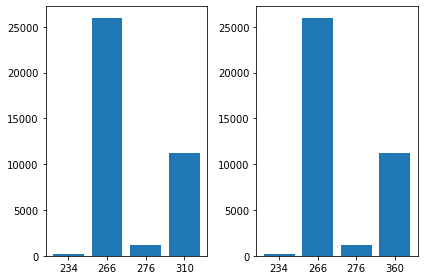

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(list(map(str, unique_width_values)), count_width_values);
ax2.bar(list(map(str, unique_height_values)), count_height_values);
plt.tight_layout()

In [ ]:
mask_types = ['lb + sb + st', 'lb + sb', 'lb + st', 'sb + st', 'lb', 'sb', 'st']
mask_types_count = [
    # All 3 masks
    len(df_preprocess.loc[(df_preprocess['large_bowel'] != 'nan') & (df_preprocess['small_bowel'] != 'nan') & (df_preprocess['stomach'] != 'nan')]),
    # Just 2 masks
    len(df_preprocess.loc[(df_preprocess['large_bowel'] != 'nan') & (df_preprocess['small_bowel'] != 'nan') & (df_preprocess['stomach'] == 'nan')]),
    len(df_preprocess.loc[(df_preprocess['large_bowel'] != 'nan') & (df_preprocess['small_bowel'] == 'nan') & (df_preprocess['stomach'] != 'nan')]),
    len(df_preprocess.loc[(df_preprocess['large_bowel'] == 'nan') & (df_preprocess['small_bowel'] != 'nan') & (df_preprocess['stomach'] != 'nan')]),
    # Just 1 mask
    len(df_preprocess.loc[(df_preprocess['large_bowel'] != 'nan') & (df_preprocess['small_bowel'] == 'nan') & (df_preprocess['stomach'] == 'nan')]),
    len(df_preprocess.loc[(df_preprocess['large_bowel'] == 'nan') & (df_preprocess['small_bowel'] != 'nan') & (df_preprocess['stomach'] == 'nan')]),
    len(df_preprocess.loc[(df_preprocess['large_bowel'] == 'nan') & (df_preprocess['small_bowel'] == 'nan') & (df_preprocess['stomach'] != 'nan')])
]

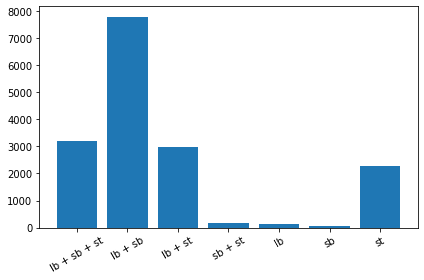

In [ ]:
plt.bar(mask_types, mask_types_count);
plt.xticks(rotation=30);
plt.tight_layout();

In [ ]:
slice_unique = np.sort(df_preprocess['slice_id'].unique())
slice_count = np.array([(df_preprocess['slice_id'] == each).sum() for each in slice_unique])

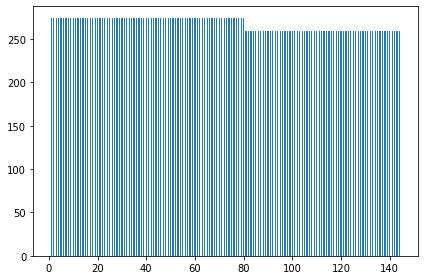

In [ ]:
# plt.figure(figsize = (4,2), dpi=200)
plt.bar(slice_unique, slice_count, width=0.5)
plt.tight_layout()

<BarContainer object of 2 artists>

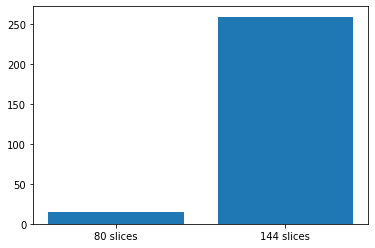

In [ ]:
tmp = np.unique(slice_count)
plt.bar(['80 slices', '144 slices'], [tmp[1]-tmp[0], tmp[0]])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed_all(1)

df_val = df_preprocess.sample(int(args.val_split*len(df_preprocess)))
df_train = df_preprocess.drop(df_val.index)

img_transforms = transforms.Compose([transforms.Resize((args.img_width, args.img_height))])
mask_transforms = transforms.Compose([transforms.Resize((args.img_width, args.img_height), interpolation=InterpolationMode.NEAREST)])

train_dataset = UWDataset(df_train, transform=img_transforms, target_transform=mask_transforms, pad_to_aspect_ratio=1)
val_dataset = UWDataset(df_val, transform=img_transforms, target_transform=mask_transforms, pad_to_aspect_ratio=1)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                             shuffle=True, worker_init_fn=seed_worker)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size,
                                             shuffle=True)

[Using Seed: 1 ]


In [ ]:
img, mask = next(iter(train_dataloader))

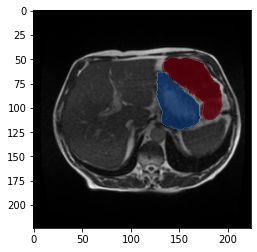

In [ ]:
plt.imshow(img[0, 0], cmap='gray')
plt.imshow(mask[0, 0], alpha=0.75*(mask[0, 0] > 0.5), cmap='Reds', interpolation=None)
plt.imshow(mask[0, 1], alpha=0.75*(mask[0, 1] > 0.5), cmap='Greens', interpolation=None)
plt.imshow(mask[0, 2], alpha=0.75*(mask[0, 2] > 0.5), cmap='Blues', interpolation=None)

## Entrenamiento

In [ ]:
def train(model, dataloader, device, optimizer, scheduler, loss_fn):
    model.train()
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
    scheduler.step()

In [ ]:
def test(model, dataloader, device, loss_fn, metrics_fn=None):
    loss_total = 0.0
    metrics_total = 0.0
    data_len = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = loss_fn(preds, y)
#             metrics_total += metrics_fn(preds, y) * y.shape[0]
            data_len += y.shape[0]
            loss_total += loss
#         return loss_total/len(dataloader), 1-metrics_total/data_len
        return loss_total/len(dataloader)

In [ ]:
model = smp.Unet(
    encoder_name=args.arch.lower(),        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
    activation=None
)
model.to(device);

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [ ]:
loss_fn = smp.losses.DiceLoss(mode='multilabel')
metrics_fn = None
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, (args.min_lr/args.lr)**(1/args.epochs))

best_dice_loss = 100

for epoch in range(1, args.epochs):
    print('\nEpoch {}'.format(epoch))
    train(model, train_dataloader, device, optimizer, scheduler, loss_fn)
    train_loss = test(model, train_dataloader, device, loss_fn)
    
    print('Training Loss: {:.4f}'.format(train_loss))    
    test_loss = test(model, val_dataloader, device, loss_fn)
    
    print('Test Loss: {:.4f}'.format(test_loss))
    
    if test_loss < best_dice_loss:
        torch.save(model, os.path.join('../ckpt', 'best_' + args.log_name + '.pt'))
        best_dice_loss = test_loss
        print('Saving best model')
    

torch.save(model, os.path.join('./data/ckpt', 'last_' + args.log_name + '.pt'))


Epoch 1


  0%|          | 0/26948 [00:00<?, ?it/s]